# eICU data exploration

Query results can be extracted like so:

```qr = get_query_result(user="dtank", database="eicu", query="SELECT count(*) FROM patient;")```

CSV files of certain data can be extracted like so:

```extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/noteTRY.csv", variablestring="patientUnitStayID, notePath, noteText", table="note")```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# !pip install tableone
from tableone import TableOne, load_dataset
# !pip install icd9cms
from icd9cms.icd9 import search

from dataExtraction import get_query_result, extract_csv, get_df

## Basic dataset characteristics


In [2]:
print("Number of patients in the dataset: ", 
      get_query_result(user="dtank", database="eicu", query="SELECT COUNT(DISTINCT uniquePid) FROM patient;")[0][0])
print("Number of admissions in the dataset: ",
     get_query_result(user="dtank", database="eicu", query="SELECT COUNT(*) FROM patient;")[0][0])
print("Number of hospitals in the dataset: ",
     get_query_result(user="dtank", database="eicu", query="SELECT COUNT(DISTINCT hospitalID) FROM patient;")[0][0])
print("Number of wards in the dataset: ",
     get_query_result(user="dtank", database="eicu", query="SELECT COUNT(DISTINCT wardID) FROM patient;")[0][0])
print("Number of admission diagnoses in the dataset: ",
     get_query_result(user="dtank", database="eicu", query="SELECT COUNT(DISTINCT apacheAdmissionDx) FROM patient;")[0][0])
print("Number of ICU units in the dataset: ",
     get_query_result(user="dtank", database="eicu", query="SELECT COUNT(DISTINCT unitType) FROM patient;")[0][0])
print("Years in the dataset: ",
     get_query_result(user="dtank", database="eicu", query="SELECT DISTINCT hospitalDischargeYear FROM patient;"))

# also include country, year, version of the dataset

Number of patients in the dataset:  139367
Number of admissions in the dataset:  200859
Number of hospitals in the dataset:  208
Number of wards in the dataset:  335
Number of admission diagnoses in the dataset:  393
Number of ICU units in the dataset:  8
Years in the dataset:  [(2014,), (2015,)]


## Patient characteristics

In [3]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/patientCharacteristics.csv",
            variablestring="patientunitstayid, uniquePid, gender, age, ethnicity, admissionHeight, hospitalDischargeStatus, unitType, admissionWeight, unitDischargeStatus", 
            table="patient")

COPY 200859
data extracted


### Patient characteristics statistics table
We extract and preprocess the data, then use the [tableone](https://pypi.org/project/tableone/) package to make a patient characteristics table for both hospital and ICU mortality. 

In [4]:
patientChar = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/patientCharacteristics.csv")
patientChar

,patientunitstayid,uniquepid,gender,age,ethnicity,admissionheight,hospitaldischargestatus,unittype,admissionweight,unitdischargestatus
0,141168,002-34851,Female,70,Caucasian,152.4,Expired,Med-Surg ICU,84.3,Expired
1,141178,002-33870,Female,52,Caucasian,162.6,Alive,Med-Surg ICU,54.4,Alive
2,141179,002-33870,Female,52,Caucasian,162.6,Alive,Med-Surg ICU,NaN,Alive
3,141194,002-5276,Male,68,Caucasian,180.3,Alive,CTICU,73.9,Alive
4,141196,002-37665,Male,71,Caucasian,162.6,Alive,Med-Surg ICU,NaN,Alive
...,...,...,...,...,...,...,...,...,...,...
200854,3353235,035-16382,Male,50,Caucasian,175.3,Alive,Cardiac ICU,90.0,Alive
200855,3353237,035-751,Female,79,Caucasian,162.6,Alive,MICU,78.4,Alive
200856,3353251,035-5166,Male,73,African American,177.8,Alive,Cardiac ICU,102.0,Alive
200857,3353254,035-19511,Male,81,Caucasian,185.4,Alive,Med-Surg ICU,83.9,Alive


In [5]:
patientChar['age'] = patientChar['age'].replace("> 89", "89") # replace all > 89 with 89 entries 
patientChar['age'] = patientChar['age'].astype('float') # convert age from strings to floats

# renaming conventions
patientChar['gender'] = patientChar['gender'].replace("Other", "Other/Unknown") 
patientChar['gender'] = patientChar['gender'].replace("Unknown", "Other/Unknown") 

patientChar['hospitaldischargestatus'] = patientChar['hospitaldischargestatus'].replace('Alive', 'Alive at hospital discharge')
patientChar['hospitaldischargestatus'] = patientChar['hospitaldischargestatus'].replace('Expired', 'Dead at hospital discharge')

patientChar['unitdischargestatus'] = patientChar['unitdischargestatus'].replace('Alive', 'Alive at ICU discharge')
patientChar['unitdischargestatus'] = patientChar['unitdischargestatus'].replace('Expired', 'Dead at ICU discharge')

# only for unique patients
patientChar = patientChar.drop_duplicates(subset='uniquepid')
patientChar

,patientunitstayid,uniquepid,gender,age,ethnicity,admissionheight,hospitaldischargestatus,unittype,admissionweight,unitdischargestatus
0,141168,002-34851,Female,70.0,Caucasian,152.4,Dead at hospital discharge,Med-Surg ICU,84.3,Dead at ICU discharge
1,141178,002-33870,Female,52.0,Caucasian,162.6,Alive at hospital discharge,Med-Surg ICU,54.4,Alive at ICU discharge
3,141194,002-5276,Male,68.0,Caucasian,180.3,Alive at hospital discharge,CTICU,73.9,Alive at ICU discharge
4,141196,002-37665,Male,71.0,Caucasian,162.6,Alive at hospital discharge,Med-Surg ICU,NaN,Alive at ICU discharge
6,141203,002-23234,Female,77.0,Caucasian,160.0,Alive at hospital discharge,Med-Surg ICU,70.2,Alive at ICU discharge
...,...,...,...,...,...,...,...,...,...,...
200852,3353216,035-2734,Female,50.0,African American,165.1,Alive at hospital discharge,CTICU,55.4,Alive at ICU discharge
200854,3353235,035-16382,Male,50.0,Caucasian,175.3,Alive at hospital discharge,Cardiac ICU,90.0,Alive at ICU discharge
200855,3353237,035-751,Female,79.0,Caucasian,162.6,Alive at hospital discharge,MICU,78.4,Alive at ICU discharge
200857,3353254,035-19511,Male,81.0,Caucasian,185.4,Alive at hospital discharge,Med-Surg ICU,83.9,Alive at ICU discharge


In [6]:
columns = ['gender', 'age', 'ethnicity', 'admissionheight', 'admissionweight', 'unittype']
categorical = ['gender', 'ethnicity', 'unittype']
labels = {'gender' : 'Gender', 
          'age' : 'Age', 
          'ethnicity' : 'Ethnicity', 
          'admissionheight' : 'Height', 
          'admissionweight' : 'Weight', 
          'unittype' : 'ICU Unit'}

patientCharTableHospital = TableOne(patientChar, columns=columns, categorical=categorical, rename=labels, 
                                    label_suffix=True, nonnormal=['age'], groupby='hospitaldischargestatus', pval=True)

patientCharTableICU = TableOne(patientChar, columns=columns, categorical=categorical, rename=labels, 
                               label_suffix=True, nonnormal=['age'], groupby='unitdischargestatus', pval=True)

In [7]:
patientCharTableHospital
# print(patientCharTableHospital.tabulate(tablefmt = 'latex')) # print a latex formatted table

Grouped by hospitaldischargestatus                                                                                 
                                                                Missing           Overall Alive at hospital discharge Dead at hospital discharge P-Value
n                                                                                  139367                      124981                      13129        
Gender, n (%)       Female                                          111      64038 (46.0)                57289 (45.9)                6144 (46.8)  <0.001
                    Male                                                     75176 (54.0)                67579 (54.1)                6963 (53.1)        
                    Other/Unknown                                                42 (0.0)                    26 (0.0)                   16 (0.1)        
Age, median [Q1,Q3]                                                  82  65.0 [53.0,77.0]            64.0 [52.0,76.0]           72.0 [61.0,82.0]  <0.001
Ethnicity, n (%)    African American                               1780      14672 (10.7)                13255 (10.7)                1303 (10.1)   0.141
                    Asian                                                      2338 (1.7)                  2073 (1.7)                  232 (1.8)        
                    Caucasian                                               107724 (78.3)                96567 (78.3)               10198 (78.7)        
                    Hispanic                                                   5233 (3.8)                  4685 (3.8)                  523 (4.0)        
                    Native American                                             964 (0.7)                   871 (0.7)                   87 (0.7)        
                    Other/Unknown                                              6656 (4.8)                  5945 (4.8)                  621 (4.8)        
Height, mean (SD)                                                  3153      169.3 (13.9)                169.4 (13.8)               168.3 (14.6)  <0.001
Weight, mean (SD)                                                  8170       83.9 (26.9)                 84.2 (26.7)                80.7 (28.1)  <0.001
ICU Unit, n (%)     CCU-CTICU                                         0       11404 (8.2)                 10386 (8.3)                  979 (7.5)  <0.001
                    CSICU                                                      5164 (3.7)                  4821 (3.9)                  305 (2.3)        
                    CTICU                                                      4597 (3.3)                  4302 (3.4)                  261 (2.0)        
                    Cardiac ICU                                                9362 (6.7)                  8243 (6.6)                 1026 (7.8)        
                    MICU                                                      11721 (8.4)                 10093 (8.1)                1546 (11.8)        
                    Med-Surg ICU                                             77928 (55.9)                69767 (55.8)                7359 (56.1)        
                    Neuro ICU                                                 10678 (7.7)                  9641 (7.7)                  916 (7.0)        
                    SICU                                                       8513 (6.1)                  7728 (6.2)                  737 (5.6)        
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: gender.

In [8]:
patientCharTableICU
# print(patientCharTable.tabulate(tablefmt = 'latex')) # print a latex formatted table

Grouped by unitdischargestatus                                                                       
                                                            Missing           Overall Alive at ICU discharge Dead at ICU discharge P-Value
n                                                                              139367                 130454                  8898        
Gender, n (%)       Female                                      111      64038 (46.0)           59974 (46.0)           4055 (45.6)  <0.001
                    Male                                                 75176 (54.0)           70346 (54.0)           4824 (54.3)        
                    Other/Unknown                                            42 (0.0)               29 (0.0)              13 (0.1)        
Age, median [Q1,Q3]                                              82  65.0 [53.0,77.0]       65.0 [52.0,76.0]      71.0 [59.0,81.0]  <0.001
Ethnicity, n (%)    African American                           1780      14672 (10.7)           13771 (10.7)            901 (10.3)   0.167
                    Asian                                                  2338 (1.7)             2187 (1.7)             151 (1.7)        
                    Caucasian                                           107724 (78.3)          100814 (78.3)           6895 (78.7)        
                    Hispanic                                               5233 (3.8)             4933 (3.8)             300 (3.4)        
                    Native American                                         964 (0.7)              902 (0.7)              62 (0.7)        
                    Other/Unknown                                          6656 (4.8)             6199 (4.8)             457 (5.2)        
Height, mean (SD)                                              3153      169.3 (13.9)           169.3 (13.8)          168.6 (15.0)  <0.001
Weight, mean (SD)                                              8170       83.9 (26.9)            84.0 (26.8)           81.8 (27.5)  <0.001
ICU Unit, n (%)     CCU-CTICU                                     0       11404 (8.2)            10720 (8.2)             682 (7.7)  <0.001
                    CSICU                                                  5164 (3.7)             4905 (3.8)             259 (2.9)        
                    CTICU                                                  4597 (3.3)             4438 (3.4)             158 (1.8)        
                    Cardiac ICU                                            9362 (6.7)             8632 (6.6)             730 (8.2)        
                    MICU                                                  11721 (8.4)            10689 (8.2)           1029 (11.6)        
                    Med-Surg ICU                                         77928 (55.9)           72924 (55.9)           4996 (56.1)        
                    Neuro ICU                                             10678 (7.7)            10136 (7.8)             542 (6.1)        
                    SICU                                                   8513 (6.1)             8010 (6.1)             502 (5.6)        
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: gender.

### Patient characteristics: mortality per ethnicity and age plot
We preprocess the patient characteristics data, extract the amount of deaths per ethnicity and age group, divide these by their total ethnicity amount (ethnicity normalized) to get the ethnicity normalized mortality rate per 1000 people. 

In [9]:
patientCharPlot = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/patientCharacteristics.csv")
patientCharPlot = patientCharPlot.drop_duplicates(subset='uniquepid')

lastcat = [str(x) for x in list(range(80, 90))]
lastcat.append('> 89')

patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(0, 20))], '0-20'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(20, 30))], '20-30'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(30, 40))], '30-40'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(40, 50))], '40-50'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(50, 60))], '50-60'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(60, 70))], '60-70'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys([str(x) for x in list(range(70, 80))], '70-80'))
patientCharPlot['age'] = patientCharPlot['age'].replace(dict.fromkeys(lastcat, '80+'))
patientCharPlot

,patientunitstayid,uniquepid,gender,age,ethnicity,admissionheight,hospitaldischargestatus,unittype,admissionweight,unitdischargestatus
0,141168,002-34851,Female,70-80,Caucasian,152.4,Expired,Med-Surg ICU,84.3,Expired
1,141178,002-33870,Female,50-60,Caucasian,162.6,Alive,Med-Surg ICU,54.4,Alive
3,141194,002-5276,Male,60-70,Caucasian,180.3,Alive,CTICU,73.9,Alive
4,141196,002-37665,Male,70-80,Caucasian,162.6,Alive,Med-Surg ICU,NaN,Alive
6,141203,002-23234,Female,70-80,Caucasian,160.0,Alive,Med-Surg ICU,70.2,Alive
...,...,...,...,...,...,...,...,...,...,...
200852,3353216,035-2734,Female,50-60,African American,165.1,Alive,CTICU,55.4,Alive
200854,3353235,035-16382,Male,50-60,Caucasian,175.3,Alive,Cardiac ICU,90.0,Alive
200855,3353237,035-751,Female,70-80,Caucasian,162.6,Alive,MICU,78.4,Alive
200857,3353254,035-19511,Male,80+,Caucasian,185.4,Alive,Med-Surg ICU,83.9,Alive


In [10]:
mortEthAge = patientCharPlot.groupby(['ethnicity', 'age'], as_index=False).hospitaldischargestatus.value_counts()
mortEthAge = mortEthAge.tail(-1)
mortEthAge = mortEthAge.iloc[::2].reset_index(drop=True)
mortEthAge

,ethnicity,age,hospitaldischargestatus,count
0,African American,0-20,Expired,5
1,African American,20-30,Expired,29
2,African American,30-40,Expired,75
3,African American,40-50,Expired,124
4,African American,50-60,Expired,235
5,African American,60-70,Expired,320
6,African American,70-80,Expired,280
7,African American,80+,Expired,235
8,Asian,0-20,Expired,1
9,Asian,20-30,Expired,3


In [11]:
AfAmTotal = len(patientChar[patientChar['ethnicity'] == 'African American']['ethnicity'])
AsianTotal = len(patientChar[patientChar['ethnicity'] == 'Asian']['ethnicity'])
CaucasTotal = len(patientChar[patientChar['ethnicity'] == 'Caucasian']['ethnicity'])
NatAmTotal = len(patientChar[patientChar['ethnicity'] == 'Native American']['ethnicity'])
UnknTotal = len(patientChar[patientChar['ethnicity'] == 'Other/Unknown']['ethnicity'])

In [12]:
AfAm = (mortEthAge[mortEthAge['ethnicity'] == 'African American']['count']/AfAmTotal*1000).to_list()
Asian = (mortEthAge[mortEthAge['ethnicity'] == 'Asian']['count']/AsianTotal*1000).to_list()
Caucas = (mortEthAge[mortEthAge['ethnicity'] == 'Caucasian']['count']/CaucasTotal*1000).to_list()
NatAm = (mortEthAge[mortEthAge['ethnicity'] == 'Native American']['count']/NatAmTotal*1000).to_list()
Unkn = (mortEthAge[mortEthAge['ethnicity'] == 'Other/Unknown']['count']/UnknTotal*1000).to_list()

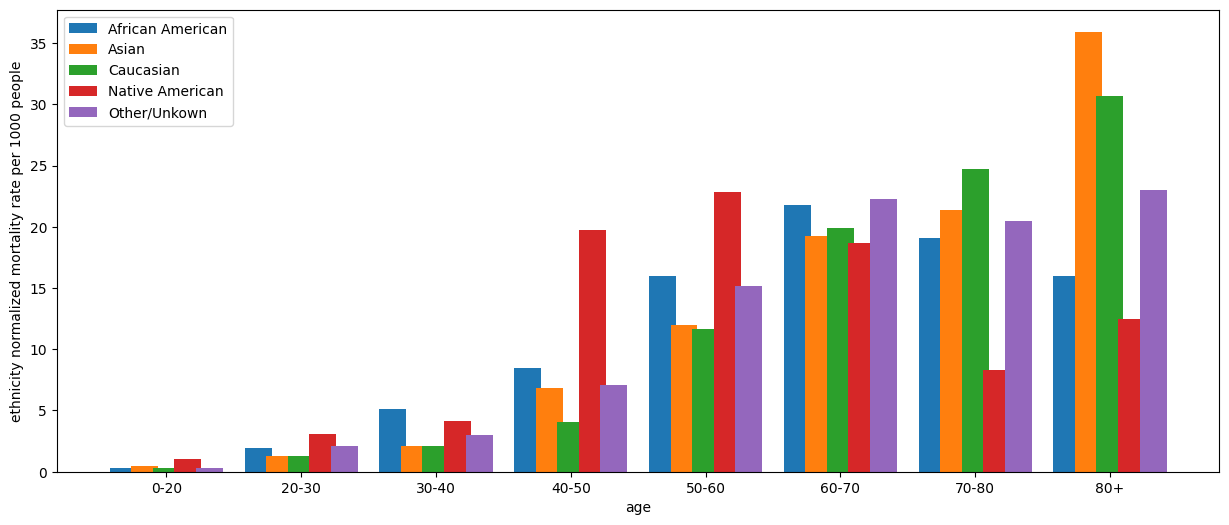

In [13]:
X = np.arange(8)
fig = plt.figure(figsize=(15,6))
margin = 0.8
plt.bar(X + -0.4 * margin, AfAm, width = 0.2)
plt.bar(X + -0.2 * margin, Asian, width = 0.2)
plt.bar(X , Caucas, width = 0.2)
plt.bar(X + 0.2 * margin, NatAm, width = 0.2)
plt.bar(X + 0.4 * margin, Unkn, width = 0.2)
plt.xlabel('age')
plt.ylabel('ethnicity normalized mortality rate per 1000 people')
plt.legend(labels=['African American', 'Asian', 'Caucasian', 'Native American', 'Other/Unkown'])
plt.xticks((0, 1, 2, 3, 4, 5, 6, 7), ('0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+'))

plt.show()

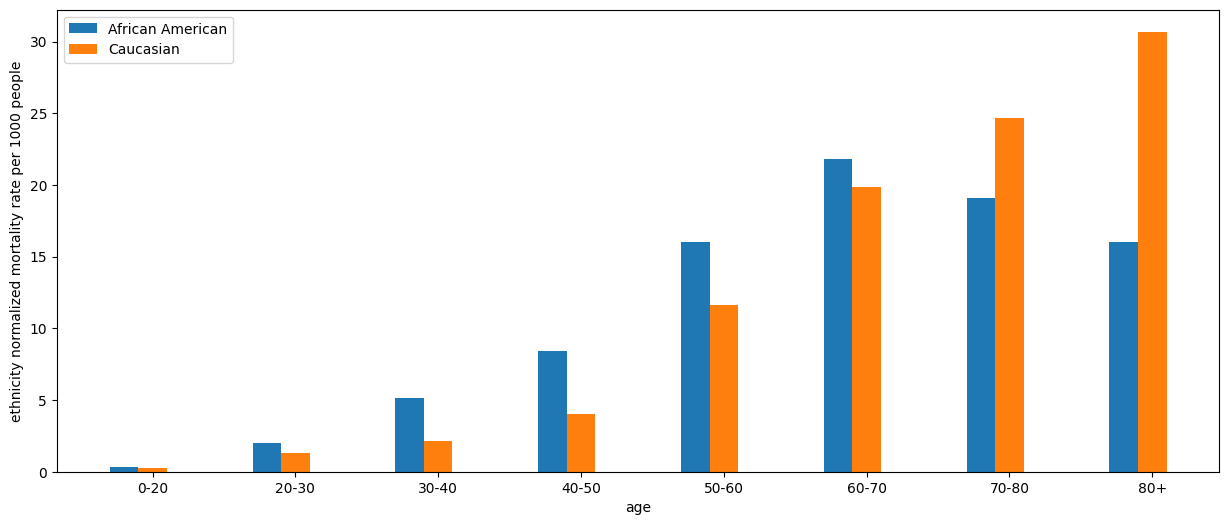

In [14]:
X = np.arange(8)
fig = plt.figure(figsize=(15,6))
margin = 0.8
plt.bar(X + -0.2, AfAm, width = 0.2)
plt.bar(X , Caucas, width = 0.2)
plt.xlabel('age')
plt.ylabel('ethnicity normalized mortality rate per 1000 people')
plt.legend(labels=['African American', 'Caucasian'])
plt.xticks((0, 1, 2, 3, 4, 5, 6, 7), ('0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80+'))

plt.show()

### Patient characteristics: frequency of hospital visits plot
We preprocess the data, find the sum of the amount of hospital visits and plot it.

In [15]:
PatientCharPatVis = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/patientCharacteristics.csv")
numuniquepats = len(np.unique(PatientCharPatVis['uniquepid']))
visitAmount = PatientCharPatVis.uniquepid.value_counts()
visitAmount = visitAmount.value_counts().rename_axis('visit_amount').reset_index(name='counts')
visitAmount['percentage'] = visitAmount['counts']/numuniquepats * 100
percentage5 = visitAmount[4:]['percentage'].sum()
counts5 = visitAmount[4:]['counts'].sum()
visitAmount = visitAmount.iloc[:4]
visitAmount.loc[len(visitAmount.index)] = [5, counts5, percentage5]
visitAmount['percentage'] = visitAmount['percentage'].round().astype('int')
visitAmount['visit_amount'] = visitAmount['visit_amount'].astype('int')
visitAmount

,visit_amount,counts,percentage
0,1,100884.0,72
1,2,26554.0,19
2,3,6612.0,5
3,4,2899.0,2
4,5,2418.0,2


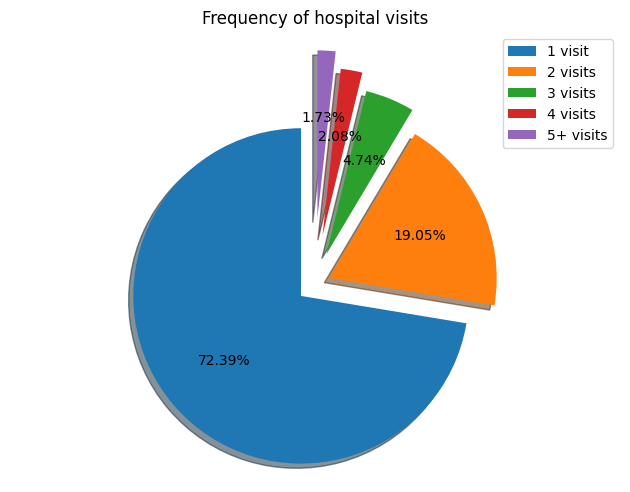

In [16]:
labels= ['1 visit', '2 visits', '3 visits', '4 visits', '5+ visits']
sizes= visitAmount['counts']
plt.pie(sizes, startangle=90, shadow=True,explode=(0.1, 0.1, 0.2, 0.3, 0.4), autopct='%1.2f%%')
plt.axis('equal')
plt.legend(labels)
plt.tight_layout()
plt.title('Frequency of hospital visits')

plt.show()

## (Admission) Diagnoses

In [17]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/diagnoses.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.apacheAdmissionDx, patient.hospitalDischargeStatus, patient.unitDischargeStatus, diagnosis.diagnosisString, diagnosis.ICD9Code", table="patient, diagnosis")

COPY 2710672
data extracted


In [18]:
diagnoses = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/diagnoses.csv")
diagnoses

,patientunitstayid,uniquepid,apacheadmissiondx,hospitaldischargestatus,unitdischargestatus,diagnosisstring,icd9code
0,141470,002-56630,"Obstruction/other, surgery for (with or withou...",Alive,Alive,cardiovascular|shock / hypotension|sepsis,"038.9, A41.9"
1,141470,002-56630,"Obstruction/other, surgery for (with or withou...",Alive,Alive,renal|disorder of kidney|acute renal failure,"584.9, N17.9"
2,141470,002-56630,"Obstruction/other, surgery for (with or withou...",Alive,Alive,cardiovascular|shock / hypotension|hypotension,"458.9, I95.9"
3,141470,002-56630,"Obstruction/other, surgery for (with or withou...",Alive,Alive,renal|disorder of urinary tract / renal system...,"586, N19"
4,141515,002-48364,"Sepsis, unknown",Expired,Alive,neurologic|altered mental status / pain|change...,"780.09, R41.82"
...,...,...,...,...,...,...,...
2710667,3353113,035-10030,Drug withdrawal,Alive,Alive,cardiovascular|vascular disorders|hypertension...,"401.9, I10"
2710668,3353194,035-2735,Cardiac arrest (with or without respiratory ar...,Expired,Expired,cardiovascular|cardiac arrest|cardiac arrest,"427.5, I46.9"
2710669,3353194,035-2735,Cardiac arrest (with or without respiratory ar...,Expired,Expired,cardiovascular|cardiac arrest|cardiac arrest,"427.5, I46.9"
2710670,3353194,035-2735,Cardiac arrest (with or without respiratory ar...,Expired,Expired,renal|disorder of kidney|acute renal failure,"584.9, N17.9"


In [19]:
def code_to_string(x):
    try: 
        codeandtext = str(search(x)).split(":")[0:2]
        return codeandtext[0] + ": " + codeandtext[1]
    except:
        return 'None'

/tmp/ipykernel_676573/1061600306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnoses['icd9code'] = diagnoses['icd9code'].str.split(',').str[0] # get only the first icd9 code


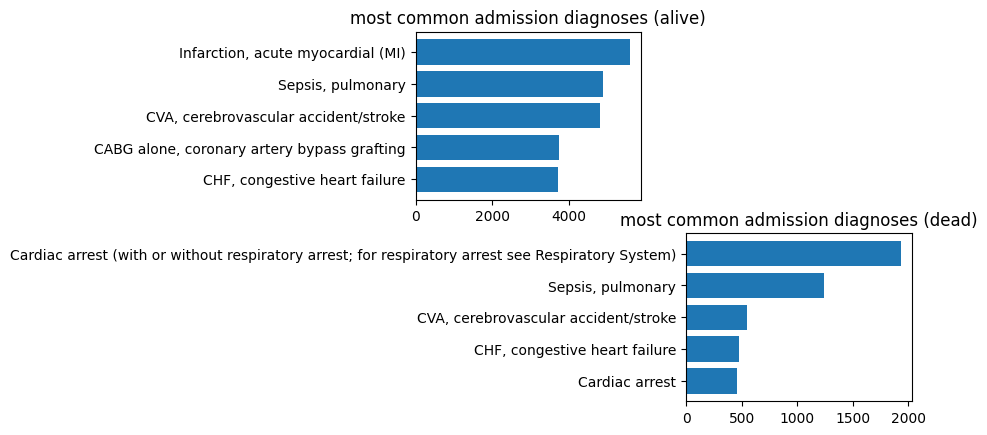

In [20]:
diagnoses = diagnoses.drop_duplicates(subset='uniquepid') # get unique patients
diagnoses['icd9code'] = diagnoses['icd9code']c # get only the first icd9 code

# most common admission diagnoses
admdiag = diagnoses.groupby('hospitaldischargestatus', as_index=False)['apacheadmissiondx'].value_counts().reset_index(drop=True)
admdiag_alive = admdiag[admdiag['hospitaldischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
admdiag_dead = admdiag[admdiag['hospitaldischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

# Make a data definition
count_alive = admdiag_alive['count']
bars_alive = admdiag_alive['apacheadmissiondx']

count_dead = admdiag_dead['count']
bars_dead = admdiag_dead['apacheadmissiondx'].to_list()
bars_dead[0] = 'Cardiac arrest'

y_pos = np.arange(len(bars_dead))
 
# Create the first subplot
plt.subplot(221)
plt.barh(y_pos, count_alive)
plt.yticks(y_pos, bars_alive)
# plt.xlabel('Occurrences')
plt.title('most common admission diagnoses (alive)')
 
# Create the second subplot
plt.subplot(224)
plt.barh(y_pos, count_dead)
plt.yticks(y_pos, bars_dead)
plt.title('most common admission diagnoses (dead)')
 
# Display the plot
plt.show()

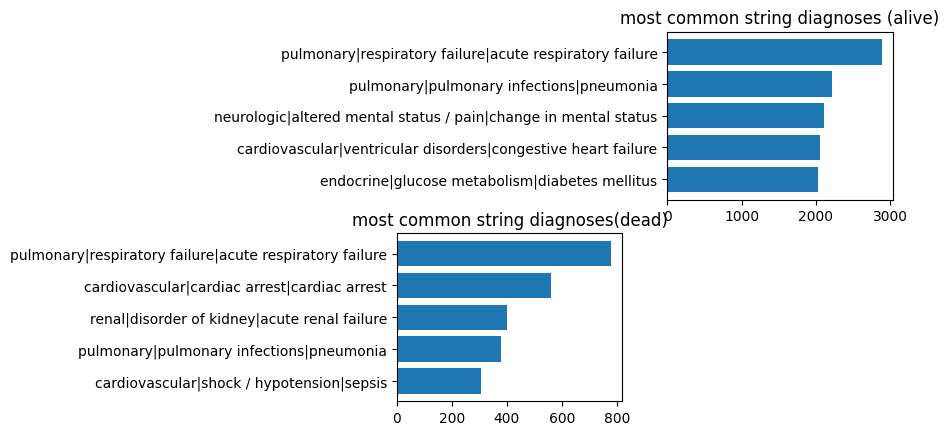

In [21]:
# most common diagnosis strings
diagstring = diagnoses.groupby('hospitaldischargestatus', as_index=False)['diagnosisstring'].value_counts().reset_index(drop=True)
diagstring_alive = diagstring[diagstring['hospitaldischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
diagstring_dead = diagstring[diagstring['hospitaldischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

# Make a data definition
count_alive = diagstring_alive['count']
bars_alive = diagstring_alive['diagnosisstring']

count_dead = diagstring_dead['count']
bars_dead = diagstring_dead['diagnosisstring']
# bars_dead[0] = 'Cardiac arrest'

y_pos = np.arange(len(bars_alive))
 
# Create the first subplot
plt.subplot(222)
plt.barh(y_pos, count_alive)
plt.yticks(y_pos, bars_alive)
plt.title('most common string diagnoses (alive)')
 
# Create the second subplot
plt.subplot(223)
plt.barh(y_pos, count_dead)
plt.yticks(y_pos, bars_dead)
plt.title('most common string diagnoses(dead)')
 
# Display the plot
plt.show()

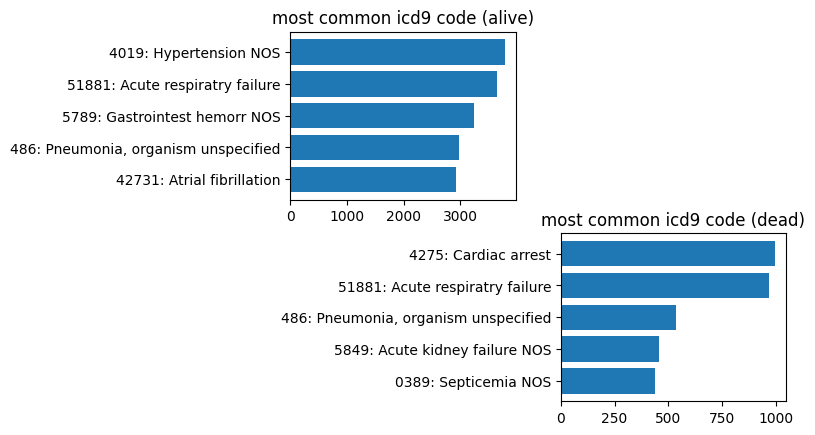

In [22]:
# most common icd9 code diagnosis
icd9code = diagnoses.groupby('hospitaldischargestatus', as_index=False)['icd9code'].value_counts().reset_index(drop=True)
icd9code_alive = icd9code[icd9code['hospitaldischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
icd9code_dead = icd9code[icd9code['hospitaldischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)
icd9code_alive['icd9codetostring'] = icd9code['icd9code'].apply(code_to_string)
icd9code_dead['icd9codetostring'] = icd9code['icd9code'].apply(code_to_string)

# Make a data definition
count_alive = icd9code_alive['count']
bars_alive = icd9code_alive['icd9codetostring']

count_dead = icd9code_dead['count']
bars_dead = icd9code_dead['icd9codetostring']

y_pos = np.arange(len(bars_alive))
 
# Create the first subplot
plt.subplot(221)
plt.barh(y_pos, count_alive)
plt.yticks(y_pos, bars_alive)
plt.title('most common icd9 code (alive)')
 
# Create the second subplot
plt.subplot(224)
plt.barh(y_pos, count_dead)
plt.yticks(y_pos, bars_dead)
plt.title('most common icd9 code (dead)')
 
# Display the plot
plt.show()

## Hospital information

In [23]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/hospital.csv", variablestring="patient.hospitalID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, hospital.teachingstatus, hospital.region", table="patient, hospital", joinon='hospitalID')

COPY 200859
data extracted


In [66]:
hospital = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/hospital.csv")
hospital_teachingstatus = hospital.groupby(['teachingstatus'], as_index=False).hospitaldischargestatus.value_counts()
hospital_teachingstatus = hospital_teachingstatus[hospital_teachingstatus['hospitaldischargestatus']=='Expired']
hospital_teachingstatus

,teachingstatus,hospitaldischargestatus,count
1,f,Expired,12726
3,t,Expired,5278


In [73]:
total_nonteaching = (hospital['teachingstatus']=='f').sum()
total_teaching = (hospital['teachingstatus']=='t').sum()


mortality_teaching = hospital_teachingstatus['count'][1]/total_teaching*1000
mortality_nonteaching = hospital_teachingstatus['count'][3]/total_nonteaching*1000

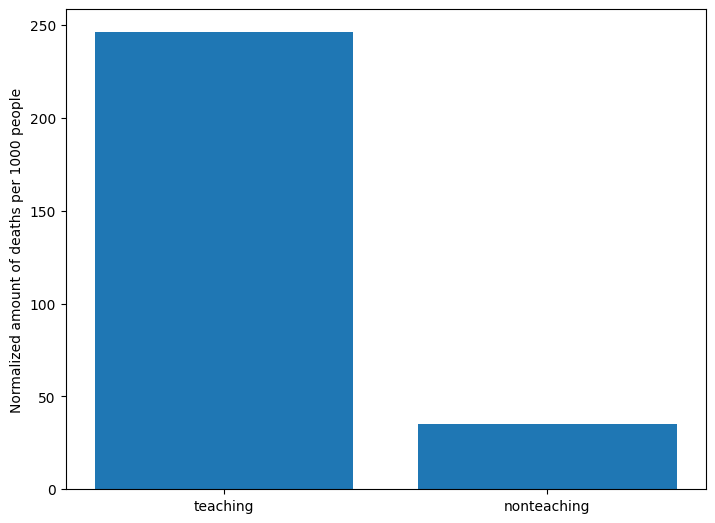

In [93]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
teachingstatus = ['teaching', 'nonteaching']
norm_mort = [mortality_teaching, mortality_nonteaching]
ax.bar(teachingstatus, norm_mort)
ax.set_ylabel('Normalized amount of deaths per 1000 people')
plt.show()

In [90]:
hospital_region = hospital.groupby(['region'], as_index=False).hospitaldischargestatus.value_counts()
hospital_region = hospital_region[hospital_region['hospitaldischargestatus']=='Expired']

total_midwest = (hospital['region']=='Midwest').sum()
total_northeast = (hospital['region']=='Northeast').sum()
total_south = (hospital['region']=='South').sum()
total_west = (hospital['region']=='West').sum()

mortality_midwest = hospital_region['count'][1]/total_midwest*1000
mortality_northeast = hospital_region['count'][3]/total_northeast*1000
mortality_south = hospital_region['count'][5]/total_south*1000
mortality_west = hospital_region['count'][7]/total_west*1000


hospital_region

,region,hospitaldischargestatus,count
1,Midwest,Expired,5499
3,Northeast,Expired,1612
5,South,Expired,6136
7,West,Expired,3730


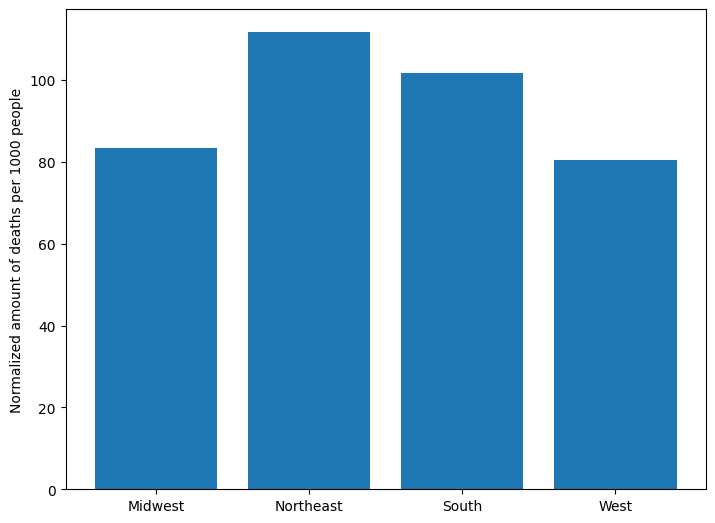

In [91]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
region = hospital_region['region']
norm_mort = [mortality_midwest, mortality_northeast, mortality_south, mortality_west]
ax.bar(region, norm_mort)
ax.set_ylabel('Normalized amount of deaths per 1000 people')
plt.show()

## Past History

In [94]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/pastHistory.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, pastHistory.pasthistoryvaluetext", table="patient, pasthistory")

COPY 1149180
data extracted


In [102]:
pastHistory = pd.read_csv('/home/dtank/data/volume_2/eicu_csv/pastHistory.csv')
pastHistory = pastHistory[pastHistory.pasthistoryvaluetext != 'Performed'] # remove the 'performed' value rows since it does not give insightful information
pastHistory

,patientunitstayid,uniquepid,hospitaldischargestatus,unitdischargestatus,pasthistoryvaluetext
0,141197,002-37665,Alive,Alive,NoHealthProblems
1,141208,002-34521,Alive,Alive,NoHealthProblems
2,141233,002-8979,Alive,Alive,CHF
3,141233,002-8979,Alive,Alive,breast
5,141265,002-24408,Alive,Alive,medication dependent
...,...,...,...,...,...
1149171,3353197,035-18808,Alive,Alive,MS
1149172,3353197,035-18808,Alive,Alive,non-medication dependent
1149174,3353197,035-18808,Alive,Alive,MS
1149175,3353197,035-18808,Alive,Alive,hypertension requiring treatment


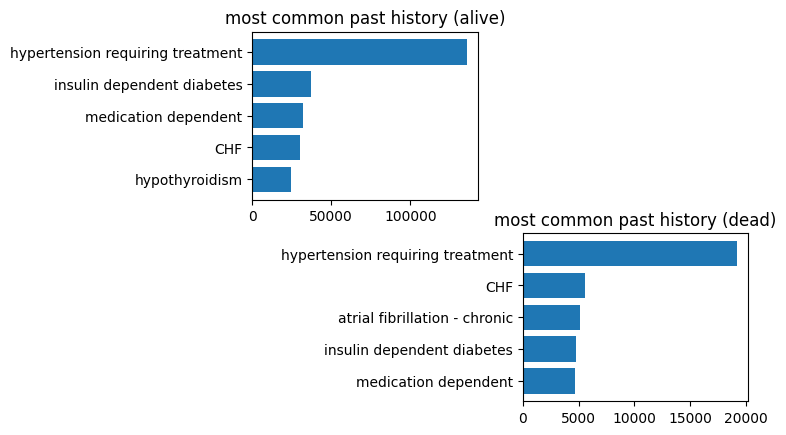

In [103]:
pasthist = pastHistory.groupby('hospitaldischargestatus', as_index=False)['pasthistoryvaluetext'].value_counts().reset_index(drop=True)
pasthist_alive = pasthist[pasthist['hospitaldischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
pasthist_dead = pasthist[pasthist['hospitaldischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

count_alive = pasthist_alive['count']
bars_alive = pasthist_alive['pasthistoryvaluetext']

count_dead = pasthist_dead['count']
bars_dead = pasthist_dead['pasthistoryvaluetext']

y_pos = np.arange(len(bars_alive))
 
# Create the first subplot
plt.subplot(221)
plt.barh(y_pos, count_alive)
plt.yticks(y_pos, bars_alive)
plt.title('most common past history (alive)')
 
# Create the second subplot
plt.subplot(224)
plt.barh(y_pos, count_dead)
plt.yticks(y_pos, bars_dead)
plt.title('most common past history (dead)')
 
# Display the plot
plt.show()

## Treatment

In [104]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/treatment.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, treatment.treatmentstring", table="patient, treatment")

COPY 3688745
data extracted


In [138]:
treatment = pd.read_csv('/home/dtank/data/volume_2/eicu_csv/treatment.csv')
treatment['treatmentvalue'] = treatment['treatmentstring'].str.split('|').str[-1] # add the treatment value
treatment

,patientunitstayid,uniquepid,hospitaldischargestatus,unitdischargestatus,treatmentstring,treatmentvalue
0,242083,003-7975,Alive,Alive,gastrointestinal|medications|antiemetic|seroto...,ondansetron
1,242083,003-7975,Alive,Alive,surgery|infection|therapeutic antibacterials|s...,cefoxitin
2,242083,003-7975,Alive,Alive,pulmonary|medications|bronchodilator,bronchodilator
3,242083,003-7975,Alive,Alive,gastrointestinal|consultations|Surgery consult...,Surgery consultation
4,242083,003-7975,Alive,Alive,cardiovascular|intravenous fluid|normal saline...,normal saline administration
...,...,...,...,...,...,...
3688740,3353197,035-18808,Alive,Alive,cardiovascular|shock|inotropic agent|norepinep...,norepinephrine <= 0.1 micrograms/kg/min
3688741,3353197,035-18808,Alive,Alive,cardiovascular|shock|blood product administrat...,transfusion of 1-2 units prbc's
3688742,3353235,035-16382,Alive,Alive,cardiovascular|ventricular dysfunction|intrave...,IV furosemide
3688743,3353237,035-751,Alive,Alive,cardiovascular|non-operative procedures|diagno...,transthoracic echocardiography


In [128]:
# top 20 treatment amountsper patient

treatmentAmount = treatment.uniquepid.value_counts()
treatmentAmount = treatmentAmount.value_counts().rename_axis('treatment_amount').reset_index(name='counts')
treatmentAmount[:20]

,treatment_amount,counts
0,1,13830
1,2,11791
2,3,9475
3,4,7993
4,5,6347
5,6,5472
6,7,4475
7,8,4003
8,9,3319
9,10,3012


In [130]:
print('maximum treatment amounts:', treatmentAmount['treatment_amount'].max())

maximum treatment amounts: 8123


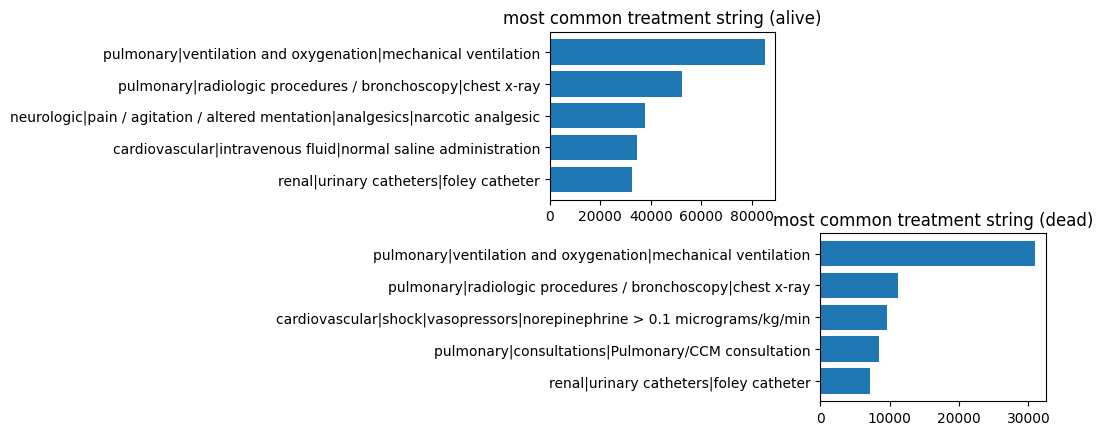

In [136]:
treatmentstring = treatment.groupby('hospitaldischargestatus', as_index=False)['treatmentstring'].value_counts().reset_index(drop=True)
treatmentstring_alive = treatmentstring[treatmentstring['hospitaldischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
treatmentstring_dead = treatmentstring[treatmentstring['hospitaldischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

count_alive = treatmentstring_alive['count']
bars_alive = treatmentstring_alive['treatmentstring']

count_dead = treatmentstring_dead['count']
bars_dead = treatmentstring_dead['treatmentstring']

y_pos = np.arange(len(bars_alive))
 
# Create the first subplot
plt.subplot(221)
plt.barh(y_pos, count_alive)
plt.yticks(y_pos, bars_alive)
plt.title('most common treatment string (alive)')
 
# Create the second subplot
plt.subplot(224)
plt.barh(y_pos, count_dead)
plt.yticks(y_pos, bars_dead)
plt.title('most common treatment string (dead)')
 
# Display the plot
plt.show()

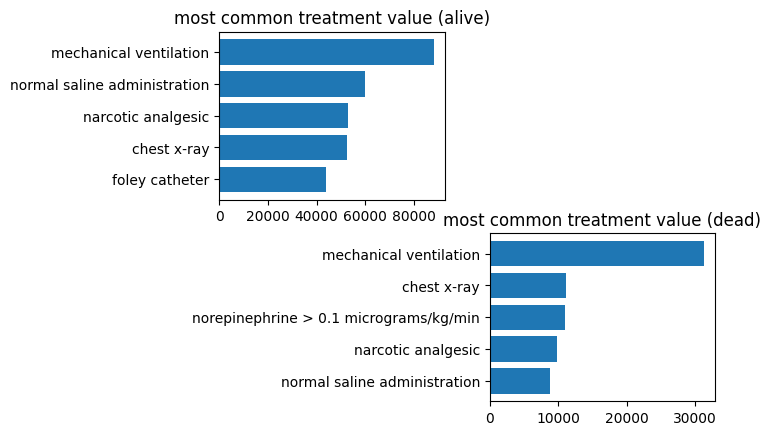

In [140]:
treatmentvalue = treatment.groupby('hospitaldischargestatus', as_index=False)['treatmentvalue'].value_counts().reset_index(drop=True)
treatmentvalue_alive = treatmentvalue[treatmentvalue['hospitaldischargestatus'] == 'Alive'][:5].sort_values('count', ascending=True)
treatmentvalue_dead = treatmentvalue[treatmentvalue['hospitaldischargestatus'] == 'Expired'][:5].sort_values('count', ascending=True)

count_alive = treatmentvalue_alive['count']
bars_alive = treatmentvalue_alive['treatmentvalue']

count_dead = treatmentvalue_dead['count']
bars_dead = treatmentvalue_dead['treatmentvalue']

y_pos = np.arange(len(bars_alive))
 
# Create the first subplot
plt.subplot(221)
plt.barh(y_pos, count_alive)
plt.yticks(y_pos, bars_alive)
plt.title('most common treatment value (alive)')
 
# Create the second subplot
plt.subplot(224)
plt.barh(y_pos, count_dead)
plt.yticks(y_pos, bars_dead)
plt.title('most common treatment value (dead)')
 
# Display the plot
plt.show()

## Predicted and actual mortality

In [141]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/apachepatientresult.csv", variablestring="apachescore, predictedicumortality, actualicumortality, predictedhospitalmortality, actualhospitalmortality", table="apachepatientresult")

COPY 297064
data extracted


In [149]:
apachepatientresult = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/apachepatientresult.csv")
icumortality_apache = apachepatientresult.groupby('actualicumortality')['apachescore'].mean()
icumortality_mortality = apachepatientresult.groupby('actualicumortality')['predictedicumortality'].mean()
hospitalmortality_apache = apachepatientresult.groupby('actualhospitalmortality')['apachescore'].mean()
hospitalmortality_mortality = apachepatientresult.groupby('actualhospitalmortality')['predictedhospitalmortality'].mean()

print(icumortality_apache)
print()
print(icumortality_mortality)
print()
print()
print(hospitalmortality_apache)
print()
print(hospitalmortality_mortality)

actualicumortality
ALIVE      52.423158
EXPIRED    93.339060
Name: apachescore, dtype: float64

actualicumortality
ALIVE      0.029384
EXPIRED    0.304714
Name: predictedicumortality, dtype: float64


actualhospitalmortality
ALIVE      51.530346
EXPIRED    86.843852
Name: apachescore, dtype: float64

actualhospitalmortality
ALIVE      0.012055
EXPIRED    0.224232
Name: predictedhospitalmortality, dtype: float64


## Admission drugs

In [150]:
extract_csv(saveto="/home/dtank/data/volume_2/eicu_csv/admissiondrugs.csv", variablestring="patient.patientUnitStayID, patient.uniquePID, patient.hospitalDischargeStatus, patient.unitDischargeStatus, admissionDrug.drugname, admissionDrug.drughiclseqno", table="patient, admissiondrug")

COPY 874920
data extracted


In [151]:
admissiondrug = pd.read_csv("/home/dtank/data/volume_2/eicu_csv/admissiondrugs.csv")
admissiondrug

,patientunitstayid,uniquepid,hospitaldischargestatus,unitdischargestatus,drugname,drughiclseqno
0,253168,003-27396,Alive,Alive,ESCITALOPRAM OXALATE ...,24022
1,253168,003-27396,Alive,Alive,ESCITALOPRAM OXALATE ...,24022
2,253168,003-27396,Alive,Alive,ASPIR 81 ...,1820
3,253168,003-27396,Alive,Alive,ASPIR 81 ...,1820
4,253168,003-27396,Alive,Alive,AMLODIPINE BESILATE ...,6494
...,...,...,...,...,...,...
874915,3340476,035-17594,Alive,Alive,GENTAMICIN SULFATE ...,4032
874916,3340476,035-17594,Alive,Alive,GLYBURIDE ...,802
874917,3340476,035-17594,Alive,Alive,PEPCID ...,4521
874918,3340476,035-17594,Alive,Alive,VANCOMYCIN ...,37442


In [156]:
print('avg amount of admission drugs registered:', admissiondrug['uniquepid'].value_counts().mean())
print('maximum amount of admission drugs registered: ', admissiondrug['uniquepid'].value_counts().max())

avg amount of admission drugs registered: 27.584336969544108
maximum amount of admission drugs registered:  11671
